In this notebook, we rotate the Planck $2018$ mask from Galactic coordinate to Equatorial coordinate and apodize it. 

In [1]:
import healpy as hp
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Define $\ell_{\rm max}$ and `NSIDE` the mask.

In [2]:
NSIDE_OUT = 1024
LMAX_OUT = 3 * NSIDE_OUT - 1

#plotting params
fsize = (7, 7)
fs = 20

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWa

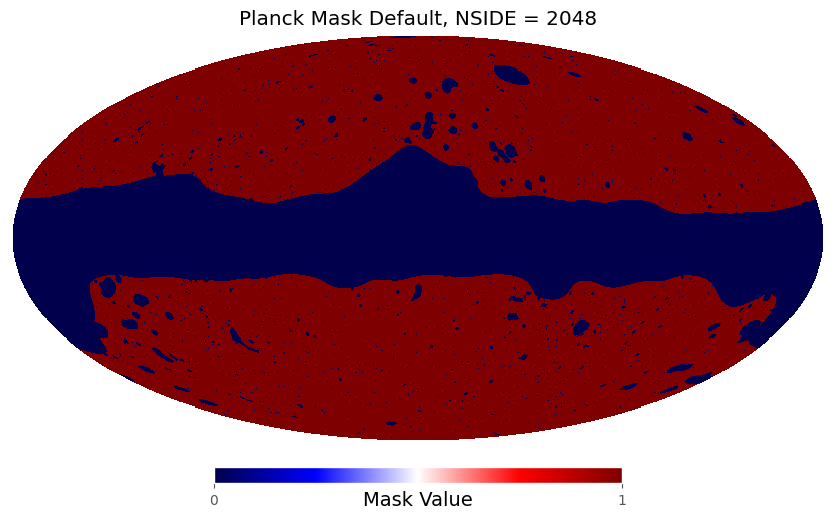

In [3]:
#cmb lensing mask
planck_mask_gal = hp.fitsfunc.read_map("/global/cscratch1/sd/tanveerk/cmb/lensing/mask.fits") 
hp.mollview(planck_mask_gal, title = "Planck Mask Default, NSIDE = 2048", unit = 'Mask Value', cmap = 'seismic', min = 0, max = 1)
plt.show()

In [4]:
# calculate power spectrum of the mask
planck_cl_gal_2048 = hp.anafast(planck_mask_gal, pol = False, lmax = LMAX_OUT)

## Rotate mask from Galactic to Equatorial 

We rotate the mask's $a_{\ell m}$ from Galactic to Equatorial. First we calculate the $a_{\ell m}$s and then rotate it. 

In [ ]:
planck_mask_gal_alms = hp.map2alm(planck_mask_gal, lmax = LMAX_OUT, pol=False) #only keep up to LMAX_OUT values

r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
planck_mask_eq_alms = r.rotate_alm(planck_mask_gal_alms)

We regenerate the mask in Equatorial basis.

### Change Equatorial basis from NSIDE = 2048 to NSIDE = 1024

In [ ]:
planck_mask_eq_1024 = hp.alm2map(planck_mask_eq_alms, nside=1024, pol = False)
planck_cl_eq_1024 = hp.anafast(planck_mask_eq_1024)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


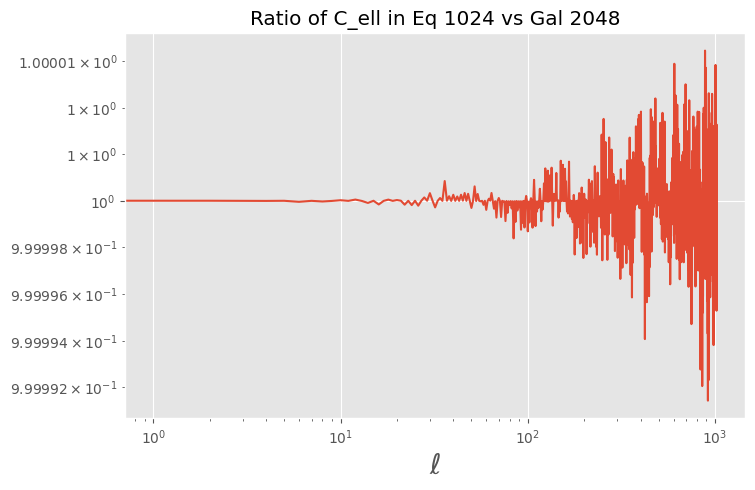

In [ ]:
plt.figure(figsize = (8,5))
plt.loglog(planck_cl_eq_1024[:1024]/planck_cl_gal_2048[:1024])
plt.xlabel(r"$\ell$", fontsize = fs)
#plt.ylabel(r"$C^{\rm mask}_{\ell}$", fontsize = fs)
plt.title("Ratio of C_ell in Eq 1024 vs Gal 2048")
plt.show()

This shows that the realization is good for our analysis. 

In [ ]:
#saving the rotated mask 
np.save("/global/cscratch1/sd/tanveerk/cmb/lensing/mask_rotated_eq_nside_1024.npy", planck_mask_eq_1024)
np.save("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_rotated_eq_nside_1024.npy", planck_mask_eq_1024)

## Apodize map

Once the mask is ready, we multiply it with the signal and then apodize the resultant to get the proper CMB lensing map. Here we demonstrate this with a simple shot noise signal map.

We at first define the apodizing function from [Singh 2021](https://arxiv.org/pdf/2105.04548.pdf) Equation $83$. 

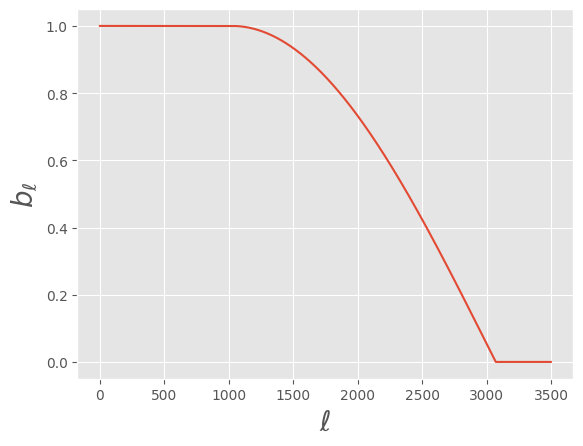

In [11]:
#define and visualize apodization function

def blcos(ell_array, ell_min = 1024, ell_max = 3071):
    blcos_array = np.zeros(ell_array.shape)
    blcos_array[ell_array <= ell_min] = 1.
    blcos_array[(ell_array > ell_min) & (ell_array < ell_max)] = \
    np.cos(np.pi/2 * (ell_array[(ell_array > ell_min) & (ell_array < ell_max)] - ell_min)/(ell_max - ell_min))
    blcos_array[ell_array >= ell_max] = 0.
    return blcos_array

blcos_array = blcos(np.arange(0, 3500))
plt.plot(blcos_array)
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$b_{\ell}$', fontsize = 20)
plt.show()

Now we show a toy example with a simple signal map.

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:396: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

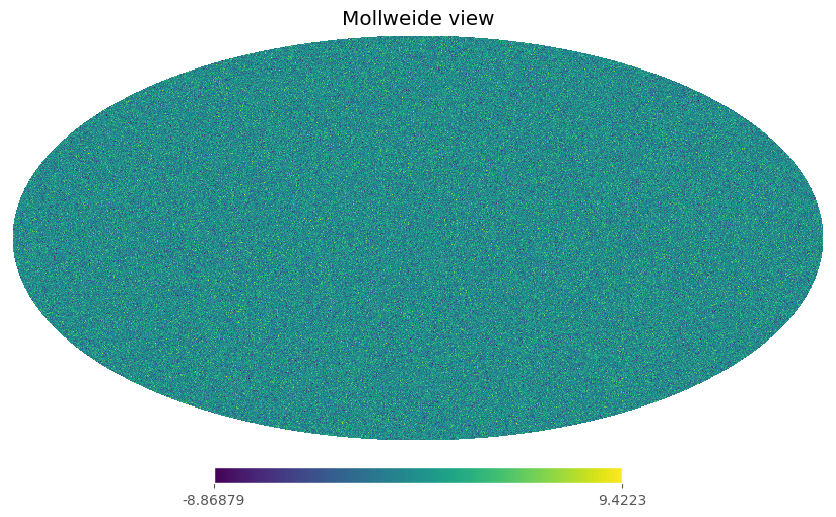

In [38]:
#tmp_map_sig = hp.synfast(cls = 1e-7*np.ones(3071), nside = 1024, pol = False) #represents a signal map
tmp_map_cl = np.genfromtxt('/global/cscratch1/sd/tanveerk/cmb/lensing/MV/nlkk.dat')[:,1] # Planck noise map for testing
tmp_map_sig = hp.synfast(tmp_map_cl, nside=1024)
hp.mollview(tmp_map_sig)
plt.show()

In [39]:
#multiply signal with mask
tmp_map_masked = tmp_map_sig * planck_mask_eq_1024

In [41]:
# apodize the resultant 
tmp_alm_masked = hp.map2alm(tmp_map_masked, pol = False)
tmp_cl_masked = hp.alm2cl(tmp_alm_masked) #calculate power spectrum

tmp_alm_masked_apodized = hp.almxfl(tmp_alm_masked, blcos_array)

In [42]:
# power spectrum of the apodized resultant 
tmp_cl_masked_apodized = hp.alm2cl(tmp_alm_masked_apodized)

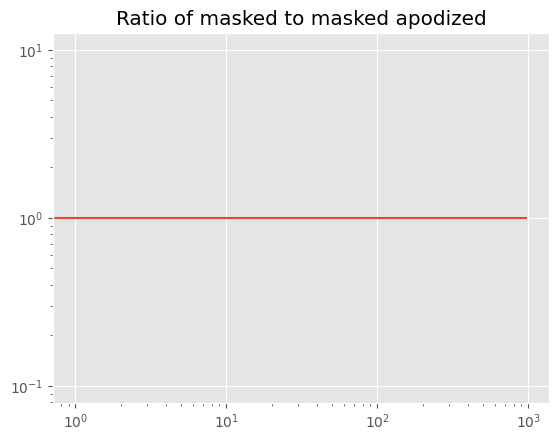

In [43]:
plt.loglog(tmp_cl_masked[50:1024]/tmp_cl_masked_apodized[50:1024])
plt.title("Ratio of masked to masked apodized")
plt.show()

In [44]:
(tmp_cl_masked[50:1024]/tmp_cl_masked_apodized[50:1024]).mean()

1.0

Thus, the apodization does not affect power spectra up to $\ell_{\rm max}$

## Is apodizing the multiplication of signal and mask the same as multiplying signal with apodized mask? 

In [45]:
# apodize the mask
planck_mask_eq_alms_apodized = hp.almxfl(planck_mask_eq_alms, blcos_array)

# generate apodized mask
planck_mask_eq_1024_apodized = hp.alm2map(planck_mask_eq_alms_apodized, nside = 1024)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [46]:
#multiply signal with apodized mask
tmp_map_with_apodized_mask = tmp_map_sig * planck_mask_eq_1024_apodized

#power spectra
tmp_cl_map_with_apo_mask = hp.anafast(tmp_map_with_apodized_mask, pol = False)

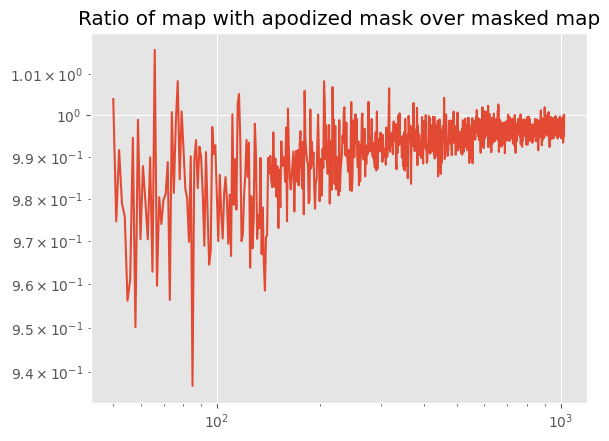

In [51]:
plt.loglog(np.arange(50, 1024), tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked[50:1024])
plt.title("Ratio of map with apodized mask over masked map")
plt.show()

In [48]:
(tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked[50:1024]).mean()

0.9934147910135749

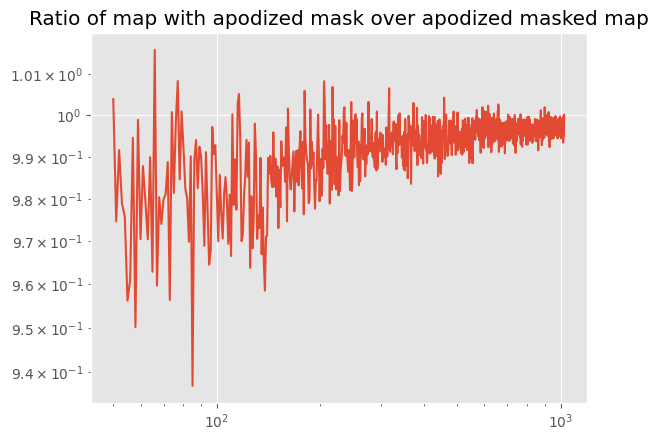

In [52]:
plt.loglog(np.arange(50, 1024), tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked_apodized[50:1024])
plt.title("Ratio of map with apodized mask over apodized masked map")
plt.show()

In [53]:
(tmp_cl_map_with_apo_mask[50:1024]/tmp_cl_masked_apodized[50:1024]).mean()

0.9934147910135749

These operations are not the same. We ought to multiply signal with mask first and then apodize rather than use an apodized mask. 